<img src="https://i.imgur.com/rrdabd5.png">

<center><h1> - TRAIN: PyTorch Model - </h1></center>

> 🦴 **Goal**: Detect and localize cervical spine fractures within CT scans.

### 🆕 What is MONAI

📌 [MONAI](https://monai.io/) is a freely available (open-source), community-supported, PyTorch-based framework for deep learning in *healthcare imaging*. It provides domain-optimized foundational capabilities for developing healthcare imaging training workflows in a native PyTorch paradigm.

<div class="alert alert-block alert-info">
  <p>💡<b> Special Thanks</b>: A huge thank you to <a href="https://www.kaggle.com/boliu0">Bo</a> and his notebook on <a href="https://www.kaggle.com/code/boliu0/monai-3d-cnn-training/notebook">MONAI 3D CNN - Training</a>. This one helped me tremendously, as it put an order into the steps I had to follow to tackle 2 areas I haven't encountered before: multi-target approach and multi-scans for same instance scenario.</p>
</div>

### ⬇ Libraries

In [1]:
# libjpeg & gdcm without internet access
# src: https://www.kaggle.com/code/awsaf49/pydicom-conda-helper

!wget 'https://anaconda.org/conda-forge/libjpeg-turbo/2.1.0/download/linux-64/libjpeg-turbo-2.1.0-h7f98852_0.tar.bz2' -q
!wget 'https://anaconda.org/conda-forge/libgcc-ng/9.3.0/download/linux-64/libgcc-ng-9.3.0-h2828fa1_19.tar.bz2' -q
!wget 'https://anaconda.org/conda-forge/gdcm/2.8.9/download/linux-64/gdcm-2.8.9-py37h500ead1_1.tar.bz2' -q
!wget 'https://anaconda.org/conda-forge/conda/4.10.1/download/linux-64/conda-4.10.1-py37h89c1867_0.tar.bz2' -q
!wget 'https://anaconda.org/conda-forge/certifi/2020.12.5/download/linux-64/certifi-2020.12.5-py37h89c1867_1.tar.bz2' -q
!wget 'https://anaconda.org/conda-forge/openssl/1.1.1k/download/linux-64/openssl-1.1.1k-h7f98852_0.tar.bz2' -q

!conda install 'libjpeg-turbo-2.1.0-h7f98852_0.tar.bz2' -c conda-forge -y
!conda install 'libgcc-ng-9.3.0-h2828fa1_19.tar.bz2' -c conda-forge -y
!conda install 'gdcm-2.8.9-py37h500ead1_1.tar.bz2' -c conda-forge -y
!conda install 'conda-4.10.1-py37h89c1867_0.tar.bz2' -c conda-forge -y
!conda install 'certifi-2020.12.5-py37h89c1867_1.tar.bz2' -c conda-forge -y
!conda install 'openssl-1.1.1k-h7f98852_0.tar.bz2' -c conda-forge -y

# MONAI 3D model
!pip install -q monai
!pip install -q git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git


######################################################################## | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Retrieving notices: ...working... done

######################################################################## | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Retrieving notices: ...working... done

######################################################################## | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Retrieving notices: ...working... done

                                                                         |   0% 

PathNotFoundError: /home/aswin/Documents/rsna/conda-4.10.1-py37h89c1867_0.tar.bz2


######################################################################## | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Retrieving notices: ...working... done

#############

/home/aswin/anaconda3/envs/jina/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Notebook Color Schemes:


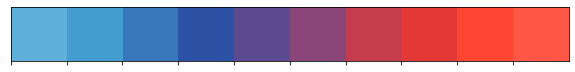

In [2]:
# Libraries
import os
import re
import gc
import cv2
import wandb
from PIL import Image
import random
import math
import shutil
from glob import glob
from tqdm import tqdm
from pprint import pprint
from time import time
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import display_html
plt.rcParams.update({'font.size': 16})

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'RSNA_SpineFructure', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'
    
my_colors = ["#5EAFD9", "#449DD1", "#3977BB", 
             "#2D51A5", "#5C4C8F", "#8B4679",
             "#C53D4C", "#E23836", "#FF4633", "#FF5746"]
CMAP1 = ListedColormap(my_colors)

print(clr.S+"Notebook Color Schemes:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

In [3]:
# PyTorch
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import torchvision
import torchvision.transforms as transforms
from warmup_scheduler import GradualWarmupScheduler
import albumentations

from sklearn.model_selection import GroupKFold, train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, cohen_kappa_score, confusion_matrix

# MONAI 3D
from monai.transforms import Randomizable, apply_transform
from monai.transforms import Compose, Resize, ScaleIntensity, ToTensor, RandAffine
from monai.networks.nets import densenet

### 🐝 W&B Fork & Run

In order to run this notebook you will need to input your own **secret API key** within the `! wandb login $secret_value_0` line. 

🐝**How do you get your own API key?**

Super simple! Go to **https://wandb.ai/site** -> Login -> Click on your profile in the top right corner -> Settings -> Scroll down to API keys -> copy your very own key (for more info check [this amazing notebook for ML Experiment Tracking on Kaggle](https://www.kaggle.com/ayuraj/experiment-tracking-with-weights-and-biases)).

<center><img src="https://i.imgur.com/fFccmoS.png" width=500></center>

In [4]:
# # 🐝 Secrets
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# secret_value_0 = user_secrets.get_secret("wandb")

! wandb login #$secret_value_0

/home/aswin/anaconda3/envs/jina/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/home/aswin/anaconda3/envs/jina/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
Aborted!


### ⬇ Helper Functions

In [5]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    
    
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
        
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]
        
        
# === 🐝 W&B ===
def save_dataset_artifact(run_name, artifact_name, path, data_type="dataset"):
    '''Saves dataset to W&B Artifactory.
    run_name: name of the experiment
    artifact_name: under what name should the dataset be stored
    path: path to the dataset'''
    
    run = wandb.init(project='RSNA_SpineFructure', 
                     name=run_name, 
                     config=CONFIG)
    artifact = wandb.Artifact(name=artifact_name, 
                              type=data_type)
    artifact.add_file(path)

    wandb.log_artifact(artifact)
    wandb.finish()
    print("Artifact has been saved successfully.")
    
    
def create_wandb_plot(x_data=None, y_data=None, x_name=None, y_name=None, title=None, log=None, plot="line"):
    '''Create and save lineplot/barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    data = [[label, val] for (label, val) in zip(x_data, y_data)]
    table = wandb.Table(data=data, columns = [x_name, y_name])
    
    if plot == "line":
        wandb.log({log : wandb.plot.line(table, x_name, y_name, title=title)})
    elif plot == "bar":
        wandb.log({log : wandb.plot.bar(table, x_name, y_name, title=title)})
    elif plot == "scatter":
        wandb.log({log : wandb.plot.scatter(table, x_name, y_name, title=title)})
        
        
def create_wandb_hist(x_data=None, x_name=None, title=None, log=None):
    '''Create and save histogram in W&B Environment.
    x_data: Pandas Series containing x values
    x_name: strings containing axis name
    title: title of the graph
    log: string containing name of log'''
    
    data = [[x] for x in x_data]
    table = wandb.Table(data=data, columns=[x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, title=title)})

# ⬇ Global Params

📌 **Note**: For the moment I run out of memory in the Kaggle environment, no matter how low I set the `epoch_size`, `img_size`, `learning_rate` etc. So I will come back with the results and models I have locally & compare.

<center><img src="https://i.imgur.com/SBhl7OB.jpg" width=800></center>

In [6]:
# 🌱 Seed    
set_seed(0)

In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(clr.S+"Device:"+clr.E, DEVICE)

# Kaggle Notebook Setup
DF_SIZE = 0.03
N_SPLITS = 5
KERNEL_TYPE = 'densenet121_baseline'
IMG_RESIZE = 100
STACK_RESIZE = 50
use_amp = False
NUM_WORKERS = 1
BATCH_SIZE = 2
LR = 0.05
OUT_DIM = 8
EPOCHS = 2

# Local Setup
# DF_SIZE = 1
# N_SPLITS = 5
# KERNEL_TYPE = 'densenet121_baseline'
# IMG_RESIZE = 150
# STACK_RESIZE = 50
# use_amp = False
# NUM_WORKERS = 4
# BATCH_SIZE = 16
# LR = 0.0005
# OUT_DIM = 8
# EPOCHS = 5

Device: cuda


📌 The difference in this competition is that **we don't have 1 target column, but 8**, as the fracture could be present in multiple locations throughout the cervical area of the spine.

In [7]:
target_cols = ['C1', 'C2', 'C3', 
               'C4', 'C5', 'C6', 'C7',
               'patient_overall']

# 1. Evaluation Metric Understanding

Below is an example of how (I think) the formula works.

As seen in [this discussion post](https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/341854) and [this weighted log loss post](https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/340392) we now know that the `w` (weight) within the given Log Loss formula can have 4 values:
* 1 - if the *label* is a vertebrae and it's NOT present
* 2 - if the *label* is a vertebrae and it IS present
* 7 - if the *label* is from *overall patient* and it's NOT present
* 14 - if the *label* is from *overall patient* and it IS present

In [8]:
# src: https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/341854
competition_weights = {
    '-' : torch.tensor([1, 1, 1, 1, 1, 1, 1, 7], dtype=torch.float, device=DEVICE),
    '+' : torch.tensor([2, 2, 2, 2, 2, 2, 2, 14], dtype=torch.float, device=DEVICE),
}

In [9]:
# Example

# Prediction (very bad)
logits = torch.tensor([[0.2221, 0.1037, 0.0739, 0.1112, 0.1026, 0.0902, 0.1597, 0.1365],
                       [0.1702, 0.0952, 0.0815, 0.1262, 0.1185, 0.1097, 0.1675, 0.1312]],
                      device=DEVICE)
print(clr.S+"Prediction:"+clr.E, "\n", logits)

# Actual
targets = torch.tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
                        [1., 0., 0., 0., 0., 0., 0., 1.]], device=DEVICE)
print(clr.S+"Target:"+clr.E, "\n", targets)

Prediction: 
 tensor([[0.2221, 0.1037, 0.0739, 0.1112, 0.1026, 0.0902, 0.1597, 0.1365],
        [0.1702, 0.0952, 0.0815, 0.1262, 0.1185, 0.1097, 0.1675, 0.1312]],
       device='cuda:0')
Target: 
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')


In [10]:
# Compute the weights
weights = targets * competition_weights['+'] + (1 - targets) * competition_weights['-']
print(clr.S+"Weights:"+clr.E, "\n", weights)

Weights: 
 tensor([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  7.],
        [ 2.,  1.,  1.,  1.,  1.,  1.,  1., 14.]], device='cuda:0')


In [11]:
# Compute losses on label and exam level
L = torch.zeros(targets.shape, device=DEVICE)

w = weights
y = targets
p = logits

for i in range(L.shape[0]):
    for j in range(L.shape[1]):
        L[i, j] = -w[i, j] * (
            y[i, j] * math.log(p[i, j]) +
            (1 - y[i, j]) * math.log(1 - p[i, j]))
        
print(clr.S+"LOSSES:"+clr.E, "\n", L)

LOSSES: 
 tensor([[ 0.2512,  0.1095,  0.0768,  0.1179,  0.1083,  0.0945,  0.1740,  1.0273],
        [ 3.5416,  0.1000,  0.0850,  0.1349,  0.1261,  0.1162,  0.1833, 28.4345]],
       device='cuda:0')


In [12]:
# Average Loss on Exam (or patient)
Exams_Loss = torch.div(torch.sum(L, dim=1), torch.sum(w, dim=1))

print(clr.S+"Exam Losses:"+clr.E, "\n", Exams_Loss)

Exam Losses: 
 tensor([0.1400, 1.4873], device='cuda:0')


> Below is a breakdown on how the formula works (this breakdown helped me A LOT - curtosy of [🦴 RSNA Fracture Detection - in-depth EDA](https://www.kaggle.com/code/samuelcortinhas/rsna-fracture-detection-in-depth-eda) notebook by [Samuel Cortinhas](https://www.kaggle.com/samuelcortinhas).

<center><img src="https://i.imgur.com/GXxNezD.jpg" width=800></center>

## ⤵ Custom Loss Function

🦴 **Side Note**: the `eps` parameter is so that we never have a `log(0)` - which is *undefined*. More on this in [this discussion post](https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/349669).

In [13]:
def get_custom_loss(logits, targets):
    
    # Compute the weights
    weights = targets * competition_weights['+'] + (1 - targets) * competition_weights['-']
    
    # Losses on label and exam level
    L = torch.zeros(targets.shape, device=DEVICE)

    w = weights
    y = targets
    p = logits
    eps=1e-8

    for i in range(L.shape[0]):
        for j in range(L.shape[1]):
            L[i, j] = -w[i, j] * (
                y[i, j] * math.log(p[i, j] + eps) +
                (1 - y[i, j]) * math.log(1 - p[i, j] + eps))
            
    # Average Loss on Exam (or patient)
    Exams_Loss = torch.div(torch.sum(L, dim=1), torch.sum(w, dim=1))
    
    return Exams_Loss

# 2. Data Split

📌 We will split the data on folds, **bearing in mind to group based on the `StudyInstanceUID`** - meaning that we want to have all CT scans from one study grouped together, not scattered throughout the training and validation data.

In [14]:
np.random.seed(0)

df = pd.read_csv("/home/aswin/data/archive/train.csv")

# Sample down df
instances = df.StudyInstanceUID.unique().tolist()
instances = random.sample(instances, k=int(len(instances)*DF_SIZE))
df = df[df["StudyInstanceUID"].isin(instances)].reset_index(drop=True)
print(clr.S+"Dataframe size:"+clr.E, df.shape)

# Create folds
kfold = GroupKFold(n_splits=N_SPLITS)
df['fold'] = -1

# Append fold
for k, (_, valid_i) in enumerate(kfold.split(df,
                                             groups=df.StudyInstanceUID)):
    df.loc[valid_i, 'fold'] = k
    
print(clr.S+"K Folds Count:"+clr.E)
df["fold"].value_counts()

Dataframe size: (60, 10)
K Folds Count:


4    12
2    12
3    12
0    12
1    12
Name: fold, dtype: int64

# 3. PyTorch Dataset

The dataset!

Another **difference** that we have in this competition is that we have **multiple CT scans** for one case. Meaning that we can use multiple images to predict if there is one or multiple fractures involved in the particular study.

This is an area I got stuck again (and this is why Bo's [notebook](https://www.kaggle.com/code/boliu0/monai-3d-cnn-training/notebook) helped clear things out for me), cuz how was I supposed to use all images at once?

I gather from multiple solutions that there are *many* ways this could be approached. In here we will use `np.stack()` to stack all the scans together.

Below is a detailed explanation on how the code below works.

<center><img src="https://i.imgur.com/sVqtvWe.jpg" width=800></center>

In [15]:
class RSNADataset(Dataset, Randomizable):
    
    def __init__(self, csv, mode, transform=None):
        self.csv = csv
        self.mode = mode
        self.transform = transform
        
    def __len__(self):
        return self.csv.shape[0]
    
    def randomize(self) -> None:
        '''-> None is a type annotation for the function that states 
        that this function returns None.'''
        
        MAX_SEED = np.iinfo(np.uint32).max + 1
        self.seed = self.R.randint(MAX_SEED, dtype="uint32")
        
    def __getitem__(self, index):
        # Set Random Seed
        self.randomize()
        
        dt = self.csv.iloc[index, :]
        study_paths = glob(f"/home/aswin/data/archive/zip_png_images{dt.StudyInstanceUID}/*")
        study_paths.sort(key=natural_keys)
        
        # Load images
        study_images = [cv2.imread(path)[:,:,::-1] for path in study_paths]
        # Stack all scans into 1
        stacked_image = np.stack([img.astype(np.float32) for img in study_images], 
                                 axis=2).transpose(3,0,1,2)
        
        if self.transform:
            if isinstance(self.transform, Randomizable):
                self.transform.set_random_state(seed=self.seed)
                
            stacked_image = apply_transform(self.transform, stacked_image)
            
        if self.mode=="test":
            return {"image": stacked_image}
        else:
            targets = torch.tensor(dt[target_cols]).float()
            return {"image": stacked_image,
                    "targets": targets}

## 3.1 Custom to_device() function

This function sends the data to **GPU**.

In [16]:
def data_to_device(data):
    
    image, targets = data.values()
    return image.to(DEVICE), targets.to(DEVICE)

## 3.2 Custom transform

*TODO: Add more transforms to the training part.*

In [17]:
train_transforms = Compose([ScaleIntensity(), 
                            Resize((IMG_RESIZE, IMG_RESIZE, STACK_RESIZE)), 
                            # TODO - add more here
                            ToTensor()])
valid_transforms = Compose([ScaleIntensity(), 
                          Resize((IMG_RESIZE, IMG_RESIZE, STACK_RESIZE)), 
                          ToTensor()])

## 🩺 3.3 Sanity Check

Let's test the function with an example and see if everything works as it should.

<center><img src="https://i.imgur.com/NRn4HDz.jpg" width=800></center>

In [18]:
# Sample data
sample_df = df.head(6)

# Instantiate Dataset object
dataset = RSNADataset(csv=sample_df, mode="train", transform=train_transforms)
# The Dataloader
dataloader = DataLoader(dataset, batch_size=3, shuffle=False)

# Output of the Dataloader
for k, data in enumerate(dataloader):
    image, targets = data_to_device(data)
    print(clr.S + f"Batch: {k}" + clr.E, "\n" +
          clr.S + "Image:" + clr.E, image.shape, "\n" +
          clr.S + "Targets:" + clr.E, targets, "\n" +
          "="*50)

ValueError: need at least one array to stack

In [20]:
del dataset, dataloader, image, targets
gc.collect()

103

# 4. Loss & Gradual Warmup

In [21]:
CRITERION = nn.BCEWithLogitsLoss(reduction='none')

def get_criterion(logits, target): 
    loss = CRITERION(logits.view(-1), target.view(-1))
    return loss

### 🦴 What is Gradual Warmup

[Warm-up](https://hasty.ai/docs/mp-wiki/scheduler/warm-up) is a way to **reduce the primacy effect for adaptive schedulers** like *Adam* or *AdamW* of the early training examples. It allows them to compute the correct gradients from the beginning on. Without it, you *may need to run a few extra epochs* to get the convergence desired.

**Learning Rate**: Using a too large learning rate may result in numerical instability *especially at the very beginning of the training*, where parameters are randomly initialized. The **warmup strategy increases the learning rate from 0 to the initial learning rate linearly** during the initial N epochs or m batches.

📍 **Example**:
* if we have a total of 5000 epochs
* if `Last Epoch` = 1000
* and we use Gradual Warmup THEN:
    * the first 1000 iterations the model will learn the corpus with **minimal learning rate** than the rate which you've specified in the model
    * from the 1001th iteration, **model will use the previously defined base learning rate**

In [22]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    '''
    src: https://www.kaggle.com/code/boliu0/monai-3d-cnn-training/notebook
    '''
    
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, 
                                                       total_epoch, after_scheduler)
    
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier 
                                                     for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier 
                    for base_lr in self.base_lrs]
        
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) 
                    for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) 
                    for base_lr in self.base_lrs]

# 5. Training Preparation

### Custom File

As I won't be doing the actual training of the model in this notebook (due to **out of memory issues**), I am also implementing within the functions an `add_in_file()` custom that will allow me to store all the logs during training and then share them with you here :).

In [23]:
def add_in_file(text, f):
    
    with open(f'log_{KERNEL_TYPE}.txt', 'a+') as f:
        print(text, file=f)

## 5.1 Train epoch

The function below does all the steps for **training** the model for only 1 epoch.

In [24]:
def train_epoch(model, dataloader, optimizer, epoch, f):
    
    # Add info to file
    print("Training...")
    add_in_file('Training...', f)
    
    # Track training time for 1 epoch
    start_time = time()
    
    # === TRAIN ===
    model.train()
    train_losses, train_comp_losses = [], []
    
    # Loop through the data
    bar = tqdm(dataloader)
    for data in bar:
        image, targets = data_to_device(data)
        
        # Train & Optimize
        optimizer.zero_grad()
        logits = model(image)
        loss = get_criterion(logits, targets)
        loss.sum().backward()
        optimizer.step()
        
        # === COMP LOSS ===
        comp_loss = get_custom_loss(logits, targets)

        # Save losses
        train_losses.append(loss.detach().cpu().numpy())
        train_comp_losses.append(comp_loss.detach().cpu().numpy().mean())
        
        gc.collect()

    # Compute Overall Loss
    mean_train_loss = np.mean(train_losses)
    mean_comp_loss = np.mean(train_comp_losses)
    
    # Save info
    total_time = round((time() - start_time)/60, 3)
    add_in_file('Train Mean Loss: {}'.format(mean_train_loss), f)
    add_in_file('Train Mean Comp Loss: {}'.format(mean_comp_loss), f)
    add_in_file('~~~ Train Time: {} mins ~~~'.format(total_time), f)
    
    # 🐝 Log to W&B
    wandb.log({"train_loss": mean_train_loss,
               "train_comp_loss": mean_comp_loss,}, step=epoch)
                
    # Print info
    print(clr.S+"Train Mean Loss:"+clr.E, mean_train_loss)
    print(clr.S+"Train Mean Comp Loss:"+clr.E, mean_comp_loss)
    print(clr.S+f"~~~ Train Time: {total_time} mins ~~~"+clr.E)
    
    return mean_train_loss

## 5.2 Validation epoch

This function does all the steps to **validate** the model for 1 epoch.

In [25]:
def valid_epoch(model, dataloader, epoch, f):
    
    # Add info to file
    print("Validation...")
    add_in_file('Validation...', f)
    
    # Track validation time for 1 epoch
    start_time = time()
    
    # === EVAL ===
    model.eval()
    valid_preds, valid_targets, valid_comp_loss = [], [], []
    
    with torch.no_grad():
        for data in dataloader:
            
            image, targets = data_to_device(data)
            logits = model(image)
            
            # === COMP LOSS ===
            comp_loss = get_custom_loss(logits, targets)
            # Save actuals, preds and losses
            valid_targets.append(targets.detach().cpu())
            valid_preds.append(logits.detach().cpu())
            valid_comp_loss.append(comp_loss.detach().cpu().numpy().mean())
            
            gc.collect()

    # Overall Valid Loss
    valid_losses = get_criterion(torch.cat(valid_preds), torch.cat(valid_targets)).numpy()
    mean_valid_loss = np.mean(valid_losses)
    
    # Overall Competition Loss
    mean_comp_valid_loss = np.mean(valid_comp_loss)
    
    # Compute Area Under Curve
    PREDS = np.concatenate(torch.cat(valid_preds).numpy())
    TARGETS = np.concatenate(torch.cat(valid_targets).numpy())
    auc = roc_auc_score(TARGETS, PREDS)
    
    # Save info
    total_time = round((time() - start_time)/60, 3)
    add_in_file('Valid Mean Loss: {}'.format(mean_valid_loss), f)
    add_in_file('Valid Mean Comp Loss: {}'.format(mean_comp_valid_loss), f)
    add_in_file('Valid AUC: {}'.format(auc), f)
    add_in_file('~~~ Valid Time: {} mins ~~~'.format(total_time), f)
    
    # 🐝 Log to W&B
    wandb.log({"valid_loss": mean_valid_loss,
               "valid_comp_loss": mean_comp_valid_loss,
               "valid_auc": auc}, step=epoch)
        
    # Print info
    print(clr.S+"Valid Mean Loss:"+clr.E, mean_valid_loss)
    print(clr.S+"Valid Mean Comp Loss:"+clr.E, mean_comp_valid_loss)
    print(clr.S+"Valid AUC:"+clr.E, auc)
    print(clr.S+f"~~~ Validation Time: {total_time} mins ~~~"+clr.E)
    
    return mean_valid_loss

## 5.3 Experiment running function

This is the main function, where we initiate the Dataset and Dataloaders, the Model, Optimizer and Scheduler and where we train and validate the model, after which we save it.

<center><img src="https://i.imgur.com/9AoM0Wt.jpg" width=800></center>

In [26]:
def run_train(fold):
    
    # 🐝 W&B Tracking
    RUN_CONFIG = CONFIG.copy()
    params = dict(model="densenet121", 
                  epochs=EPOCHS, 
                  split=N_SPLITS, 
                  batch=BATCH_SIZE, lr=LR,
                  img_size=IMG_RESIZE, stack_size=STACK_RESIZE,
                  data_size=DF_SIZE)
    RUN_CONFIG.update(params)
    run = wandb.init(project='RSNA_SpineFructure', config=CONFIG)
    
    # Get the train and valid data
    train = df[df["fold"] != fold].reset_index(drop=True)
    valid = df[df["fold"] == fold].reset_index(drop=True)
    
    # Create the Dataset & Dataloader
    train_dataset = RSNADataset(csv=train, mode="train", 
                                transform=train_transforms)
    valid_dataset = RSNADataset(csv=valid, mode="train", 
                                transform=valid_transforms)
    
    trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                             sampler=RandomSampler(train_dataset))
    validloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
    
    # Model
    model = densenet.densenet121(spatial_dims=3, in_channels=3,
                                 out_channels=OUT_DIM)
    model.class_layers.out = nn.Sequential(nn.Linear(in_features=1024, out_features=OUT_DIM), 
                                           nn.Softmax(dim=1))
    model.to(DEVICE)
    wandb.watch(model, log_freq=100) # 🐝
    
    # Optimizer & Scheduler
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler_cosine = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 2)
    scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, 
                                                total_epoch=1, 
                                                after_scheduler=scheduler_cosine)
    
    # Initiate initial loss
    valid_loss_BEST = 1000
    # Create model name
    model_file = f'{KERNEL_TYPE}_best_fold{fold}.pth'
    # Create file to save outputs
    f = open(f'log_{KERNEL_TYPE}.txt', 'a')
    
    
    for epoch in range(EPOCHS):
        
        add_in_file('======== Epoch: {}/{} ========'.format(epoch+1, EPOCHS), f)
        print("="*8, clr.S+f"Epoch {epoch}"+clr.E, "="*8)
        
        scheduler_warmup.step(epoch-1)
        
        # Train & Validate
        mean_train_loss = train_epoch(model, trainloader, optimizer, epoch, f)
        mean_valid_loss = valid_epoch(model, validloader, epoch, f)
        
        # Save model
        if mean_valid_loss < valid_loss_BEST:
            print('Saving model ...')
            add_in_file('Saving model => {}'.format(model_file), f)
            torch.save(model.state_dict(), model_file)
            valid_loss_BEST = mean_valid_loss
            
    torch.cuda.empty_cache()
    gc.collect()
    
    # 🐝 Experiment End
    wandb.finish()

# 6. Training ... 🏃‍♂️

In [27]:
# Line commented due to out of memory issue
# run_train(fold=0)

🐝 Below are some of my experiments and logs (trained on just a couple of epochs - as tests - vs 5 epochs)
<center><img src="https://i.imgur.com/f1OevsB.jpg" width=900></center>

In [28]:
# Print the output of the run (done on local machine)
f = open('../input/rsna-fracture-detection/log_densenet121_baseline.txt', 'r')
print(f.read())
f.close()

======== Epoch: 1/5 ========
Training...
Train Mean Loss: 0.7649327516555786
Train Mean Comp Loss: 7.0600905418396
~~~ Train Time: 79.658 mins ~~~
Validation...
Valid Mean Loss: 0.7653019428253174
Valid Mean Comp Loss: 7.475622177124023
Valid AUC: 0.3732621918620567
~~~ Valid Time: 19.849 mins ~~~
Saving model => densenet121_baseline_best_fold0.pth
======== Epoch: 2/5 ========
Training...
Train Mean Loss: 0.7656784057617188
Train Mean Comp Loss: 7.427681922912598
~~~ Train Time: 81.117 mins ~~~
Validation...
Valid Mean Loss: 0.7656744718551636
Valid Mean Comp Loss: 7.818461894989014
Valid AUC: 0.3647924033527289
~~~ Valid Time: 19.629 mins ~~~
======== Epoch: 3/5 ========
Training...
Train Mean Loss: 0.7657021880149841
Train Mean Comp Loss: 7.368119716644287
~~~ Train Time: 80.622 mins ~~~
Validation...
Valid Mean Loss: 0.7655552625656128
Valid Mean Comp Loss: 7.5486063957214355
Valid AUC: 0.38416925320413414
~~~ Valid Time: 19.511 mins ~~~
======== Epoch: 4/5 ========
Training...
Trai

In [29]:
# 🐝 Save Artifacts
save_dataset_artifact(run_name="save_logs", artifact_name="logs",
                      path="../input/rsna-fracture-detection/log_densenet121_baseline.txt", data_type="dataset")
save_dataset_artifact(run_name="save_model", artifact_name="model",
                      path="../input/rsna-fracture-detection/densenet121_baseline_best_fold0.pth", data_type="model")

Artifact has been saved successfully.
Artifact has been saved successfully.


<center><img src="https://i.imgur.com/0cx4xXI.png"></center>

### 🐝 W&B Dashboard

> My [W&B Dashboard](https://wandb.ai/andrada/RSNA_SpineFructure?workspace=user-andrada) - updated with training logs.

<center><video src="https://i.imgur.com/5WOgE7W.mp4" width=800 controls></center>

<center><img src="https://i.imgur.com/knxTRkO.png"></center>

### My Specs

* 🖥 Z8 G4 Workstation
* 💾 2 CPUs & 96GB Memory
* 🎮 2x NVIDIA A6000
* 💻 Zbook Studio G7 on the go